In [4]:
# help function
from transfer_learning import NeuralNet
from dataset_loader import data_loader, all_filter, get_descriptors, one_filter, data_scaler

# modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import os, sys
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from tqdm import tqdm
from scipy.stats import pearsonr

import matplotlib.pyplot as plt 

# file name and data path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_path = os.getcwd()
file_name = 'data/CrystGrowthDesign_SI.csv'

"""
Data description.

    Descriptors:
        'void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest'
    Source task:
        'H2@100 bar/243K (wt%)'
    Target tasks:
        'H2@100 bar/130K (wt%)' 'CH4@100 bar/298 K (mg/g)' '5 bar Xe mol/kg' '5 bar Kr mol/kg'
"""

descriptor_columns = ['void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest']
one_filter_columns = ['H2@100 bar/243K (wt%)'] 
another_filter_columns = ['H2@100 bar/130K (wt%)'] 

# load data
data = data_loader(base_path, file_name)
data=data.reset_index(drop=True)
# extract descriptors and gas adsorptions
one_property = one_filter(data, one_filter_columns)
descriptors = get_descriptors(data, descriptor_columns)

# prepare training inputs and outputs
X = np.array(descriptors.values, dtype=np.float32)
y = np.array(one_property.values, dtype=np.float32).reshape(len(X), )

X = data_scaler(X)
y = data_scaler(y.reshape(-1, 1)).reshape(len(X),)
epochs=1000
## hyper-parameters

seeds = np.arange(epochs)
Ns = list()
scores_epochs = list()
scores_test = list()
scores_train = list()

pred_tests = list()
grt_train_X = list()
grt_test_X = list()
grt_tests = list()
nsamples=100

input_size = 6
hidden_size_1 = 128
hidden_size_2 = 64
output_size = 1
learning_rate = .002


model = NeuralNet(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

from Statistics_helper import stratified_cluster_sample
df,t_1,t_2,y_1,y_2=stratified_cluster_sample(1,data,descriptor_columns,one_filter_columns[0],5,net_out=True)
df=df[0]
#df=df.drop("Cluster",axis=1)
interest=one_filter_columns[0]
descriptor_columns.append("Cluster")
features=descriptor_columns
from transfer_learning import MyDataset
df_train,df_val,y_df_train,y_df_val = train_test_split(df[features],df[interest],test_size=.1)
df_train[interest]=np.array(y_df_train)
df_val[interest]=(np.array(y_df_val))
first=MyDataset(df_train,interest,features)
train_loader= torch.utils.data.DataLoader(first,batch_size=100)
second=MyDataset(df_val,interest,features)
val_loader = torch.utils.data.DataLoader(second,batch_size=len(df_val))


/Users/gregcooper/Desktop/Research/TL_MOF/Statistics_helper.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Statistics_helper.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Statistics_helper.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Statistics_helper.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Statistics_helpe

In [7]:
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, MeanSquaredError
from ignite.contrib.metrics.regression import R2Score
#declared model above
def train_step(engine, batch):
    x, y = batch
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    y = y.view(-1,1)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    return loss.item()

trainer = Engine(train_step)

@trainer.on(Events.EPOCH_COMPLETED(every=1))
def log_training(engine):
    batch_loss = engine.state.output
    lr = optimizer.param_groups[0]['lr']
    e = engine.state.epoch
    n = engine.state.max_epochs
    i = engine.state.iteration
    print(f"Epoch {e}/{n} : {i} - batch loss: {batch_loss}, lr: {lr}")


trainer.run(train_loader, max_epochs=100)

Epoch 1/100 : 122 - batch loss: 0.023208312690258026, lr: 0.002
Epoch 2/100 : 244 - batch loss: 0.023299917578697205, lr: 0.002
Epoch 3/100 : 366 - batch loss: 0.023600302636623383, lr: 0.002
Epoch 4/100 : 488 - batch loss: 0.02284274250268936, lr: 0.002
Epoch 5/100 : 610 - batch loss: 0.023304825648665428, lr: 0.002
Epoch 6/100 : 732 - batch loss: 0.02345854416489601, lr: 0.002
Epoch 7/100 : 854 - batch loss: 0.022728588432073593, lr: 0.002
Epoch 8/100 : 976 - batch loss: 0.023444347083568573, lr: 0.002
Epoch 9/100 : 1098 - batch loss: 0.02291264757514, lr: 0.002
Epoch 10/100 : 1220 - batch loss: 0.022849127650260925, lr: 0.002
Epoch 11/100 : 1342 - batch loss: 0.023672999814152718, lr: 0.002
Epoch 12/100 : 1464 - batch loss: 0.022969074547290802, lr: 0.002
Epoch 13/100 : 1586 - batch loss: 0.023304585367441177, lr: 0.002
Epoch 14/100 : 1708 - batch loss: 0.02268330194056034, lr: 0.002
Epoch 15/100 : 1830 - batch loss: 0.02322879247367382, lr: 0.002
Epoch 16/100 : 1952 - batch loss: 0

State:
	iteration: 12200
	epoch: 100
	epoch_length: 122
	max_epochs: 100
	max_iters: <class 'NoneType'>
	output: 0.02078229933977127
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [8]:
for i in range(1,int(len(first)/2),10):
    i=int(i)
    print(i)
    train_loader= torch.utils.data.DataLoader(first,batch_size=i)
    trainer.run(train_loader, max_epochs=i)

1


ValueError: Argument max_epochs should be larger than the start epoch defined in the state: 1 vs 100. Please, set engine.state.max_epochs = None before calling engine.run() in order to restart the training from the beginning.

0
0.015750574
tensor(24.1117, grad_fn=<MseLossBackward0>)
0.9987069128425884


/Users/gregcooper/opt/anaconda3/envs/Transfer/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1351])) that is different to the input size (torch.Size([1351, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


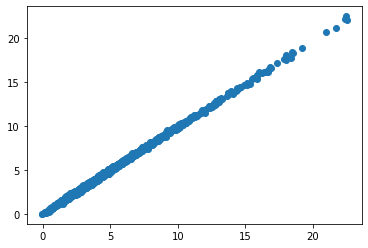

In [9]:
from sklearn.metrics import r2_score,mean_squared_error
start=0
for a,b in val_loader:
    out=model(a)
    print(start)
print(mean_squared_error(out.detach(),b))
print(criterion(out,b))
print(r2_score(out.detach().numpy(),b))
plt.scatter(out.detach().numpy(),b)

In [16]:
criterion(out,b)

/Users/gregcooper/opt/anaconda3/envs/Transfer/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1351])) that is different to the input size (torch.Size([1351, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(11.8381, grad_fn=<MseLossBackward0>)